In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
from sys import stdout
from time import time

In [3]:
X = pd.read_csv("data/X.csv")
data = X.groupby('user')

In [4]:
def remove_zeros_rows(x):
    nz = np.nonzero(x.any(axis=1))[0]
    return (x[nz, :])

def build_calendar(X):
    s = csr_matrix((X['sum'].values, (X.user.values - 1, X.day.values - 1))).todense()
    s = np.concatenate([s, np.zeros((s.shape[0], 3), dtype=np.int)], axis=1)
    return ([0] + [remove_zeros_rows(np.asarray(user.reshape(448//7, 7))) for user in s])

In [5]:
%time cal = build_calendar(X)

CPU times: user 3.9 s, sys: 137 ms, total: 4.04 s
Wall time: 4.05 s


In [6]:
%time data_pred = data.last().values
data_pred = data_pred[:, 0]

CPU times: user 130 ms, sys: 13.3 ms, total: 143 ms
Wall time: 183 ms


In [7]:
%time test = data.apply(lambda df: df.values[-2])
test = np.array(list(test))
data_test, target_test = test[:, 0], test[:, 1]

CPU times: user 887 ms, sys: 50 ms, total: 937 ms
Wall time: 979 ms


In [8]:
class msusums(object):
        
    def fit(self, cal):
        self.calendar = cal
            
    def predict(self, u, day, delta, gamma, alpha=0.5, beta=0.33):
        user_cal = self.calendar[u]
        day = (day - 1) % 7
        
        buy_week = user_cal[:, day]
        buy_week = buy_week[buy_week.nonzero()][:-1]
        
        buy_all = user_cal[user_cal.nonzero()][:-1]
        
        w1 = (1 - (np.arange(buy_week.size, 0, -1) - 1) / buy_week.size) ** delta
        w1 /= w1.sum()
        w2 = 1 / np.arange(buy_week.size, 0, -1) ** gamma
        w2 /= w2.sum()
        
        return alpha * np.sum(w1 * buy_week) +\
               beta * np.sum(w2 * buy_week) +\
               (1 - alpha - beta) * np.mean(buy_all)
    
    def predict_arr(self, data_pred, delta=0.375, gamma=3.33, alpha=0.5, beta=0.33):
        pred = []
        for u in range(len(data_pred)):
            pred += [self.predict(u + 1, data_pred[u], delta, gamma, alpha, beta)]
            
        return pred
    
    def predict_test(self, data_pred, target_pred, delta=0.375, gamma=3.33, alpha=0.42, beta=0.33, debug=False):
        start = time()
        pred = self.predict_arr(data_pred, delta, gamma, alpha, beta)
            
        if debug:
            print("{:.2f}sec elapsed for the test".format(time() - start))
        return mean_absolute_error(target_pred, pred)

In [9]:
reg = msusums()

In [10]:
reg.fit(cal)

In [11]:
%%time
num_i = 10
num_j = 10
p1 = np.linspace(0, 2, num_i)
p2 = np.linspace(0, 2, num_j)
res1 = np.zeros((num_i, num_j))
for i in range(res1.shape[0]):
    for j in range(res1.shape[1]):
        res1[i, j] = reg.predict_test(data_test, target_test, delta=p1[i], gamma=p2[j], alpha=0.5, beta=0.3)
        stdout.write('\r' + str((i * num_j + j + 1) / res1.size * 100) + '%')
print('\n')

100.0%

CPU times: user 6min 23s, sys: 260 ms, total: 6min 23s
Wall time: 6min 23s


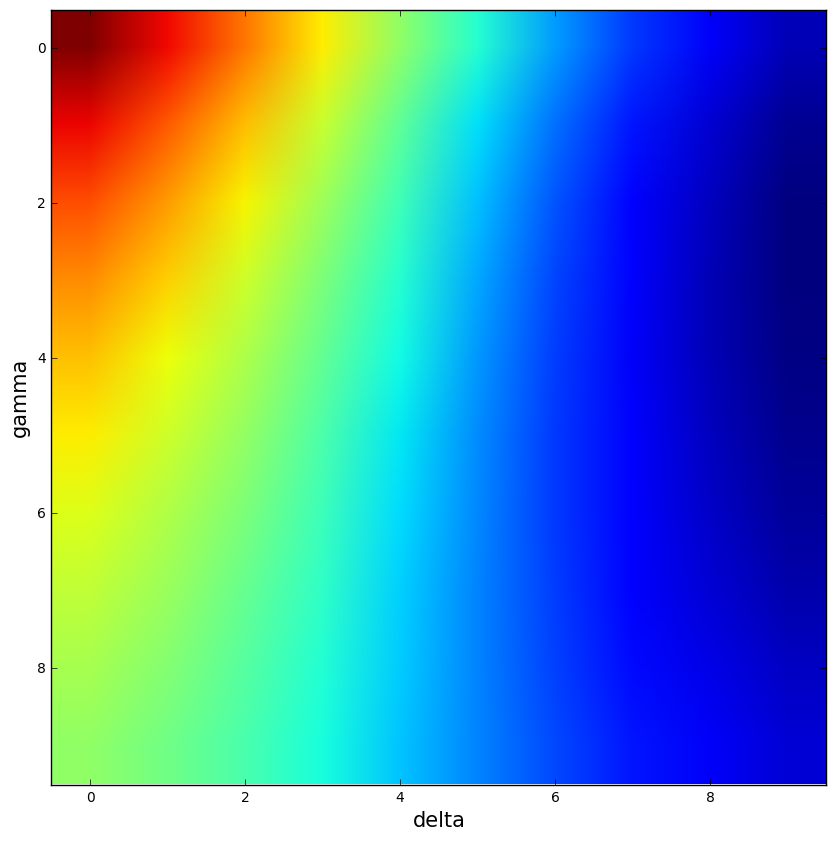

In [24]:
plt.figure(figsize=(10, 15))
plt.xlabel("delta", fontsize=15)
plt.ylabel("gamma", fontsize=15)
plt.imshow(res);

In [25]:
m = np.argmin(res)
d, g = np.unravel_index(m, (num_i, num_j))
res[d, g]

245.20620197227547

In [26]:
p1[d], p2[g]

(0.66666666666666663, 2.0)

In [18]:
%%time
num_i = 10
num_j = 10
p3 = np.linspace(0, 2, num_i)
p4 = np.linspace(0, 2, num_j)
res1 = np.zeros((num_i, num_j))
for i in range(res1.shape[0]):
    for j in range(res1.shape[1]):
        res1[i, j] = reg.predict_test(data_test, target_test, alpha=p3[i], beta=p4[i])
        stdout.write('\r' + str((i * num_j + j + 1) / res1.size * 100) + '%')
print('\n')

100.0%

CPU times: user 6min 48s, sys: 227 ms, total: 6min 49s
Wall time: 6min 48s


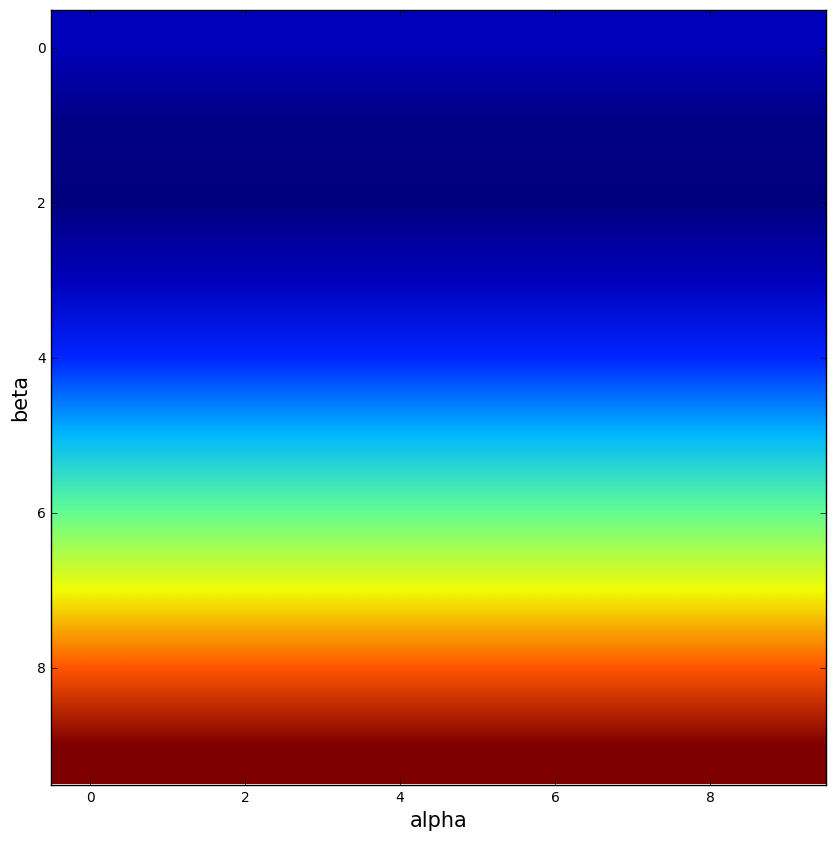

In [23]:
plt.figure(figsize=(10, 15))
plt.xlabel("alpha", fontsize=15)
plt.ylabel("beta", fontsize=15)
plt.imshow(res1);

In [27]:
m = np.argmin(res1)
d, g = np.unravel_index(m, (num_i, num_j))
res[d, g]

250.4557602413274

In [28]:
p3[d], p4[g]

(0.44444444444444442, 0.0)

In [29]:
reg.predict_test(data_test, target_test)

244.41844711316639

In [59]:
myres = reg.predict_arr(data_pred, delta=3.3, beta=0, alpha=0.7)

In [61]:
myres_csv = pd.DataFrame(data=myres, index=pd.RangeIndex(1, len(myres) + 1, name='user'), columns=['sum'])

In [62]:
myres_csv.to_csv("data/myans_1.csv")